# Génération automatique de textes (data-to-text) par adaptation d'un modèle préappris

Suite au dernier TP de `Génération automatique de textes neuronale avec une architecture encodeur/décodeur`, nous poursuivons la tâche de génération automatique de textes à partir de représentations sémantiques. Nous reprennons le même ensemble de données : le corpus [WebNLG](https://webnlg-challenge.loria.fr/challenge_2020/) qui a été mis en place pour un défi de génération à partir de données issues du _web sémantique_.

Dans le dernier TP, contrairement à l'aproche encodeur/décodeur précedente qui apprenait le modèle avec une initialisation aléatoire, nous utiliserons un modèle préappris. Ces modèles appartiennent à la catégories des modèles de fondation (_fundation models_) et sont appris sur une grande quantité de données pour obtenir une modèlisation très générique. Ils faut ensuite les adapter (_fine-tunning_) à la tâche visée.   

Dans ce TP, nous utiliserons le modèle `T5`.

Références :
- [Data to Text generation with T5; Building a simple yet advanced NLG model](https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45)
- [T5 sur huggingface](https://huggingface.co/transformers/model_doc/t5.html)

# Introduction

## Pré-apprentissage  Séquence à Séquence
En octobre 2019, des équipes de Google et de Facebook ont publié de nouveaux articles sur des modèles pré-appris `transformers` :  [T5](https://arxiv.org/abs/1910.10683) et [BART](https://arxiv.org/abs/1910.13461).

Les modèles ont obtenu de meilleures performances sur des tâches de génération, telles que le résumé automatique, grâce à deux modifications :
- Considérer un modèle transformeur complet (Encodeur de type BERT et décodeur de type GPT)
- Remplacer l'objectif de pré-apprentissage consistant à remplir des blancs (masquage) de BERT par un objectif d'apprentissage plus complexe.

### Questions
1. Donnez les principales caractéristiques et differences entre les modèles pré-entrainés `BERT`, `GPT-2`, `BART` et `T5` ? Référez-vous au cours et n'hésitez pas à faire des recherches sur internet.
2. Quelle a été la méthode d'apprentissage de `T5`?
3. Quelle est la stratégie employée pour que `T5` pré-apprennent certaines tâches.  


BERT:
Architecture : Encodeur uniquement

Objectif de pré-entraînement : Modélisation du langage masqué (MLM), prédiction de la phrase suivante (NSP)

Focus sur les tâches : Principalement des tâches de compréhension et de classification

Méthode d'apprentissage : Entraînement supervisé avec des paires de phrases et des segments de texte masqués
Stratégie employée : Les tokens sont masqués aléatoirement pour forcer le modèle à prédire le contexte et la relation entre phrases


GPT-2

Architecture : Décodeur uniquement

Objectif de pré-entraînement : Modélisation du langage autorégressive

Focus sur les tâches : Génération et complétion de texte

Méthode d'apprentissage : Entraînement non supervisé sur de grands ensembles de données textuelles

Stratégie employée : Prédiction séquentielle des mots dans un texte (modèle unidirectionnel)


BART

Architecture : Encodeur-décodeur

Objectif de pré-entraînement : Auto-encodage de débruitage (reconstruction de texte corrompu)

Focus sur les tâches : Combine les forces de BERT et GPT-2 pour diverses tâches

Méthode d'apprentissage : Entraînement supervisé avec des entrées bruyées et des cibles propres.
Stratégie employée : Diverses corruptions (suppression, remplacement, permutation) appliquées aux entrées pour apprendre à les reconstruire


T5

Architecture : Encodeur-décodeur

Objectif de pré-entraînement : Texte à texte (toutes les tâches sont formulées comme du texte à texte)

Focus sur les tâches : Approche unifiée des tâches de PNL avec une entrée et une sortie flexibles

Méthode d'apprentissage : Entraînement supervisé avec une formulation standardisée des tâches comme des problèmes de conversion d'entrée-sortie textuelles

Stratégie employée : Uniformisation des tâches en une seule approche "texte à texte" pour simplifier et généraliser l'entraînement



## Modèle - T5

`T5` peut-être utilisé pour diverses tâches de TALN dont la génération de textes. Nous utiliserons la bibliothèque `transformers` pour télécharger le modèle pré-entraîné `T5` et le mettre en oeuvre dans le code.

![T5](https://camo.githubusercontent.com/623b4dea0b653f2ad3f36c71ebfe749a677ac0a1/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f343030362f312a44304a31674e51663876727255704b657944387750412e706e67)

La bibliothèque [`transformers`](https://huggingface.co/docs/transformers/index) est développée et maintenue par l'équipe `Hugging Face`. C'est une bibliothèque open-source très utilisées avec Pytorch et Tensorflow.

Vous pouvez utiliser différents types de modèles pré-entraînés `T5` ayant des poids et une architecture différents. Les versions disponibles du modèle `T5` dans la bibliothèque `transformer` sont `t5-base`, `t5-large`, `t5-small`, `t5-3B` et `t5-11B`.

Pour en savoir plus sur le modèle T5, vous pouvez vous référer à l'article : [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683).

### Démo T5

Testez la capacité du modèle T5 avec la démo ici : https://huggingface.co/spaces/docs-demos/t5-base


# Corpus
Le [Challenge WebNLG](https://webnlg-challenge.loria.fr/challenge_2017/) consiste à générer des descriptions de triplets RDF. Les données d'entraînement consistent en des paires données/texte où les données sont un ensemble de triplets extraits de DBpedia et le texte est une verbalisation de ces triplets.

Par exemple, étant donné les trois triplets de DBpedia [a], l'objectif est de générer le texte [b] :

> [a]. (Abilene,_Texas | isPartOf | Jones_County,_Texas) (Abilene,_Texas | country | United_States) (United_States | language | English_language)

> [b]. Abilene is part of Jones County, Texas in the United States and English is the language of the United States.

Le processus de génération est illustré par la figure suivante :

<ul>
<div class="admonition example">
<p><strong>(a) Set of RDF triples</strong>
</p><div class="highlight"><pre id="__code_1"><span></span><code><span class="nt">&lt;entry</span> <span class="na">category=</span><span class="s">"City"</span> <span class="na">eid=</span><span class="s">"Id21"</span> <span class="na">shape=</span><span class="s">"(X (X) (X) (X) (X))"</span> <span class="na">shape_type=</span><span class="s">"sibling"</span> <span class="na">size=</span><span class="s">"3"</span><span class="nt">&gt;</span>
    <span class="nt">&lt;modifiedtripleset&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>Abilene,_Texas | isPartOf | Jones_County,_Texas<span class="nt">&lt;/mtriple&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>Jones_County,_Texas | country | United_States<span class="nt">&lt;/mtriple&gt;</span>
        <span class="nt">&lt;mtriple&gt;</span>United_States | language | English_language<span class="nt">&lt;/mtriple&gt;</span>        
    <span class="nt">&lt;/modifiedtripleset&gt;</span>
<span class="nt">&lt;/entry&gt;</span>
</code></pre></div><p></p>
<p><strong>(b) English text</strong></p>
<p><em>Abilene is in Jones County, Texas, U.S. The language spoken in the U.S. is English.</em></p>
<p><em>The United States uses the English language and is the location of Abilene, part of Jones County, Texas.</em></p>
<p><em>Abilene is part of Jones County, Texas and is located in the United States where the English language is spoken.</em></p>
</div>
</ul>

Les differentes version de WebNLG sont accessible à partir de ce [dépot](https://gitlab.com/shimorina/webnlg-dataset).

## Questions
1. Observez les différents répertoires `dev/test/train` dans `release_v3.0/en`, quelles sont les caractéristiques des données présentes ?

(Par exemple, différents triples, diverses catégories, `originaltripleset` vs. `modifiedtripleset` et les phrases de référence.)

> Le jeu de données `WebNLG Challenge` se compose de 21 855 paires données/texte avec un total de 8 372 données distinctes en entrée. Les données d'entrée décrivent des entités appartenant à neuf catégories DBpedia distinctes, à savoir : _astronaute_, _université_, _monument_, _bâtiment_, _personnage de bande dessinée_, _nourriture_, _aéroport_, _équipe sportive_ et _littérature_. Une nouvelle version du jeu de données a été diffusée comprenant 15 catégories DBpedia. Les nouvelles catégories comprennent _corps céleste_, _transport_, _ville_, _athlète_, _personnage politique_, _artiste_.

# Prétraitement du corpus

Les lignes de code suivantes sont facultatives, vous pouvez les utiliser si vous souhaitez sauvegarder les modèles entraînés dans votre Google Drive.

```
from google.colab import drive
drive.mount('/content/drive')
```

Il y a différentes façons pour sauvegarder le modèle, vous pourrez en apprendre plus en suivant les liens ci-dessous :

- [SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

- [Best way to save a trained model in PyTorch?](https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch)

- [How to save our model to Google Drive and reuse it](https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2)

## Installation des paquets nécessaires

Nous allons devoir utiliser un certain nombre de bilbiothèques. Executez le code ci-dessous pour les installer.

In [ ]:
# !pip install transformers
!pip install transformers[torch]
!pip install sentencepiece

Par ailleurs, pour tous le reste du TP nous aurons besoin des imports python suivants.

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import  Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from transformers.optimization import Adafactor
import time
import warnings
warnings.filterwarnings('ignore')
import zipfile
import urllib.request
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Vérification de la disponibilité du GPU
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Téléchargement des données et partitionnement


In [ ]:
# get the official data of webnlg2020 version 3.0
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
  zip_ref.extractall('web')

**NOTE IMPORTANT** :

Pour réduire le temps d'entraînement, nous n'utiliserons que les données de la catégorie **`City`** du répertoire des différents nombres de triples (p.ex. **`3triples`**) au lieu du corpus entier. Vous pourrez considérer plus d'exemples d'apprentissage pendant ce TP.

In [ ]:
"""
function to preprocess the data
get "input_text" and "target_text"
"prefix" for train and dev
keep the normal triplets as it is and join multiple triplets with “&&”
"""

def process_data(prefix):
  # Due to limit of computing resources,
  # we start with only the "City" category of various triples files for our training and validation
  # then you can try "/3triples/*.xml" for all 3triples
  # and "/**/*.xml" for all the data
  # following are some statistics:
  # TRAIN: all (1-7triples): 35190; 3triples: 7610; 3triples/City.xml: 679
  # DEV: all: 4462; 3triples: 952; City.xml: 86
  files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-/release_v3.0/en/" + \
                    prefix + "/?triples/City.xml", recursive=True) # used to use /3triples/City.xml,

  triple_re=re.compile('(\d)triples')
  data_dct={}
  for file in files:
      tree = ET.parse(file)
      root = tree.getroot()
      triples_num=int(triple_re.findall(file)[0])
      for sub_root in root:
          for ss_root in sub_root:
              strutured_master=[]
              unstructured=[]
              for entry in ss_root:
                  unstructured.append(entry.text)
                  strutured=[triple.text for triple in entry]
                  strutured_master.extend(strutured)
              unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
              strutured_master=strutured_master[-triples_num:]
              # keep the normal triplets as it is and join multiple triplets with “&&”
              strutured_master_str=(' && ').join(strutured_master)
              data_dct[strutured_master_str]=unstructured

  mdata_dct={"challenge":[], "input_text":[], "target_text":[]}
  for st,unst in data_dct.items():
      for i in unst:
          mdata_dct['challenge'].append('webNLG')
          mdata_dct['input_text'].append(st)
          mdata_dct['target_text'].append(i)
  df=pd.DataFrame(mdata_dct)
  df.to_csv('data/webNLG2020.' + prefix + '.csv')

In [ ]:
# create the data directory and load the data partitions
!mkdir -p data

for u in ['train', 'dev']:
    process_data(u)

In [ ]:
train_df=pd.read_csv('data/webNLG2020.train.csv', index_col=[0])
dev_df=pd.read_csv('data/webNLG2020.dev.csv', index_col=[0])

print("nombre d'exemples des partitions train et dev:")
print(len(train_df))
print(len(dev_df))

nombre d'exemples des partitions train et dev:
2415
295


In [ ]:
train_df.head(5)
dev_df.head(5)

,challenge,input_text,target_text
0,webNLG,"Albany,_Georgia | isPartOf | United_States && ...","Albany, Georgia is in the United States, home ..."
1,webNLG,"Albany,_Georgia | isPartOf | United_States && ...","Albany, Georgia is part of the United States o..."
2,webNLG,"Albany,_Georgia | isPartOf | United_States && ...","Albany, Georgia, is in the United States where..."
3,webNLG,"Albany,_Oregon | isPartOf | Oregon && Oregon |...",Portland is the largest city in Oregon which a...
4,webNLG,"Albany,_Oregon | isPartOf | Oregon && Oregon |...","Portland is the largest city in Oregon, the st..."


### Questions
1. Donnez le nombre d'exemples utilisés pour l'apprentissage du modèle et pour sa validation (partition dev).

nombre d'exemples des partitions train et dev:
2415,
295

2. Quel est le rôle du terme `webNLG` dans les données ?  

webNLG sert à identifier l'ensemble de données et à fournir un contexte au modèle T5 pendant l'entraînement

2. Quand vous aurez suffisemment avancé dans le TP, vous pourrez augmenter le corpus d'apprentissage. En anticipation de ce moment, regardez le code ci-dessous et essayez de comprendre comment vous pourriez l'utiliser pour progresser pas à pas (notamment pour le debuggage).

Ce code permet de réduire la taille des données d'apprentissage et de validation pour un débogage plus rapide et une augmentation progressive du corpus. En ajustant le nombre d'exemples utilisés, on peut observer l'évolution des performances du modèle et identifier les problèmes potentiels.
```
# Put a small number for fast debug
train_df=train_df.iloc[:100,:] # change the number of your training data here
print(train_df)

dev_df=dev_df.iloc[:30,:]
print(dev_df)

```

3. Que font les lignes de code ci-dessous ?

```
train_df=train_df.sample(frac = 1)
dev_df=dev_df.sample(frac = 1)
```

Ces lignes mélangent aléatoirement les lignes des DataFrames train_df et dev_df. Cela permet d'éviter les biais liés à l'ordre des données et favorise une meilleure généralisation du modèle. Le paramètre frac=1 spécifie que toutes les lignes doivent être incluses, mais dans un ordre aléatoire.

In [ ]:
#Pandas sample() is used to generate a sample random row or column from the function caller data frame.
train_df=train_df.sample(frac = 1) # frac: Float value, Returns (float value * length of data frame values ). frac cannot be used with n.
print(train_df)

print("---------------")

dev_df=dev_df.sample(frac = 1)
print(dev_df)

     challenge                                         input_text  \
492     webNLG  United_States_House_of_Representatives | isPar...   
2013    webNLG  Ann_Arbor,_Michigan | isPartOf | Washtenaw_Cou...   
1234    webNLG  Amarillo,_Texas | isPartOf | Potter_County,_Te...   
1697    webNLG  United_States | ethnicGroup | Native_Americans...   
1252    webNLG  Amarillo,_Texas | isPartOf | Potter_County,_Te...   
...        ...                                                ...   
1567    webNLG  Tarrant_County,_Texas | largestCity | Fort_Wor...   
655     webNLG  Anaheim,_California | leader | Tom_Tait && Cal...   
598     webNLG  Amarillo,_Texas | isPartOf | Potter_County,_Te...   
326     webNLG  Auburn,_Washington | isPartOf | Washington_(st...   
35      webNLG  Alabama | country | United_States && Auburn,_A...   

                                            target_text  
492   The House of Representatives, forms part of th...  
2013  Ann Arbor is part of Washtenaw County in Michi...

# Modèle de génération et apprentissage

## Chargement du modèle pré-entraîné et du tokenizer

Avant de pouvoir alimenter notre modèle avec ces textes, nous devons les prétraiter. Ceci est fait par un  `Tokenizer` de la bibliothèque 🤗 Transformers qui va convertir le texte d'entrée en sequence de tokens (y compris convertir les tokens en leurs IDs correspondants dans le vocabulaire prétraîné) et les mettre dans un format attendu par le modèle, ainsi que générer les autres entrées dont le modèle a besoin.

Pour faire tout cela, nous instancions notre tokenizer avec la méthode `AutoTokenizer.from_pretrained`, qui assurera que :

- nous obtenons un tokenizer qui correspond à l'architecture du modèle que nous voulons utiliser,
- nous téléchargeons le vocabulaire utilisé lors du pré-entraînement de ce point de contrôle (`checkpoint`) spécifique.

Ce vocabulaire sera mis en cache, afin qu'il ne soit pas téléchargé à nouveau lors de la prochaine exécution de la cellule.

Nous utiliserons `t5-base` dans ce TP, vous pouvez regarder la description du modèle [ici](https://huggingface.co/t5-base).

### Questions

1. Quel type de tokenization est mise en oeuvre dans les modèles de language pré-appris ?

2. Quel est le type de tokenizer utilisé pour `T5` ? Quel est la difference avec les tokenizers que vous avez vus ?

Faites références aux liens suivants :
- [Byte-Pair Encoding tokenization](https://huggingface.co/course/chapter6/5?fw=pt)
- [WordPiece tokenization](https://huggingface.co/course/chapter6/6?fw=pt)
- [huggingface/tokenizers](https://github.com/huggingface/tokenizers)
- https://huggingface.co/docs/transformers/main_classes/tokenizer
- [transformers.T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer)

In [ ]:
model_name = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
prefix = "WebNLG: "

def preprocess_function(df):
  # inputs, targets = [], []
  model_inputs = []
  for indx,row in df.iterrows():
    inputs = prefix + row["input_text"] + '</s>'
    targets = row['target_text']+'</s>'
    model_inputs.append(tokenizer(inputs, text_target=targets, max_length=400, truncation=True))
  return model_inputs

# Application du pre-processing à l'ensemble du dataset
train_tok = preprocess_function(train_df)
dev_tok = preprocess_function(dev_df)

## Entraînement du modèle

Les étapes de l'entraînement :

- Déplacer les données vers le GPU (facultatif)
- Effacer les gradients en utilisant `optimizer.zero_grad()`
- Effectuer une passe avant (`forward`)
- Calcul de la perte (`loss`)
- Effectuer un passage en arrière (`backward`) en utilisant `loss.backward()` pour calculer les gradients
- Effectuer un pas de l'optimiseur en utilisant `optimizer.step()` pour mettre à jour les poids.

Dans la pratique, la classe Trainer de HuggingFace implémente ces étapes pour nous. Il suffit de spécifier les paramètres à utiliser pendant l'entrainement dans un objet de type Seq2SeqTrainingArguments

In [ ]:
# By changing to False, the trainer will use the existing `model` and continue the training
# Setting to `True` reloads a fresh t5-base model

train_from_scratch = True

if train_from_scratch:
  model = T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
  model.to(dev)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name, max_length=400)

training_args = Seq2SeqTrainingArguments(
    output_dir="t5-webnlg",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=8,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    generation_max_length=128,
    # predict_with_generate=True,
    fp16=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.055900,0.742487
2,0.781900,0.679335
3,0.703600,0.659469
4,0.653300,0.651720
5,0.621600,0.648213
6,0.590300,0.643172
7,0.572100,0.644195
8,0.557300,0.647128


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1208, training_loss=0.6920110563568721, metrics={'train_runtime': 915.0956, 'train_samples_per_second': 21.113, 'train_steps_per_second': 1.32, 'total_flos': 2981657646489600.0, 'train_loss': 0.6920110563568721, 'epoch': 8.0})

Les étapes de validation et de test sont également similaires, le Trainer de HuggingFace nous calcule le loss sur les données de validation, la variable que l'on a donné pour `eval_dataset` dans les paramètre de la classe Trainer.

In [ ]:
results = trainer.evaluate()

print(results)

{'eval_loss': 0.6431723833084106, 'eval_runtime': 2.2153, 'eval_samples_per_second': 133.162, 'eval_steps_per_second': 16.702, 'epoch': 8.0}


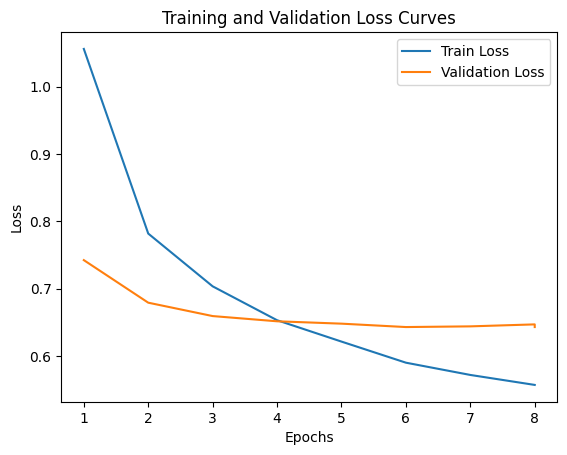

In [ ]:
# Access the log_history
log_history = trainer.state.log_history

# Extract eval_loss and train_loss

eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_epochs = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]

train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
train_epochs = [entry['epoch'] for entry in log_history if 'loss' in entry]

# Plot the learning curves
plt.plot(train_epochs, train_losses, label="Train Loss")
plt.plot(eval_epochs, eval_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

## Évaluation (inspection) du modèle

In [ ]:
# La fonction d'inférence
def generate(text):
  model.eval()
  # model.to(dev)
  input_ids = tokenizer("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  input_ids.to(dev)
  s = time.time()
  outputs = model.generate(**input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  return gen_text

### Questions
1. Quelle est la fonction de `WebNLG` ici pour la génération de texte ?

Le WebNLG est essentiel pour que le modèle T5 puisse générer du texte en langage naturel à partir de données WebNLG. Il fournit le contexte, le format des données et les instructions nécessaires pour que le modèle puisse effectuer la tâche correctement.

2. Analysez les sorties pour les exemples choisis suivants.

Les exemples montrent que T5 génère généralement des textes grammaticaux et informatifs, mais parfois avec des erreurs factuelles ou des omissions. La qualité de la sortie dépend de la complexité et de la clarté des triplets d'entrée.

3. Quelle semble être la capacité des modèles à traiter les nombres ?

T5 semble capable de traiter les nombres, les intégrant dans les phrases générées. Cependant, il peut parfois mal interpréter leur signification ou leur format, ce qui nécessite une attention particulière lors de l'évaluation des résultats.




1 triple

In [ ]:
generate('MotorSport_Vision | city | Fawkham')
# reference: MotorSport Vision is located in the city of Fawkham.

Generated in 0.84 seconds


'Fawkham is the location of the MotorSport Vision in the city of Fawk'

In [ ]:
generate('Atlanta | isPartOf | Georgia_(U.S._state)')
#Atlanta is part of Georgia , US .

Generated in 0.35 seconds


' Atlanta is part of the state of Georgia in the United States.'

In [ ]:
generate('Grenoble | capital | Alpes_(France)')

Generated in 0.43 seconds


'The capital of France is Alpes. The city of Renoble is located in the French'

2 triples

In [ ]:
generate('Nie_Haisheng | birthDate | 1964-10-13 && Nie_Haisheng | occupation | Fighter_pilot')
# reference: Nie Haisheng, born on October 13, 1964, worked as a fighter pilot.
# Nie Haisheng is a former fighter pilot who was born on October 13, 1964.
# Nie Haisheng born on 10/13/1964 is a fighter pilot.

Generated in 0.46 seconds


' Nie Haisheng was a Fighter pilot and his birthdate was 1964-10-13.'

In [ ]:
generate('Grenoble | isPartOf | Auvergne-Rhône-Alpes && Grenoble | country | France' )

Generated in 0.41 seconds


' Grenoble is part of Auvergne-Rhône-Alpes in France.'

3 triples

In [ ]:
generate('Grenoble | isPartOf | Auvergne-Rhône-Alpes && Grenoble | country | France && Auvergne-Rhône-Alpes | language | French_language ')

Generated in 0.46 seconds


'Grenoble is part of Auvergne-Rhône-Alpes in France, where French'

In [ ]:
generate('Saint_Petersburg | foundingDate | 1703-05-27 && Olga_Bondareva | deathPlace | Saint_Petersburg && Saint_Petersburg | areaTotal | 1439.0')

# Saint Petersburg was founded on May 27, 1703 and has a total area of 1439.0, Olga Bondareva passed away at Saint Petersburg.
# Saint Petersburg, where Olga Bondareva died, was founded on the 27th of May, 1703 and has a total area of approximately 1439 km2.
# Saint Petersburg, where Olga Bondareva died, was founded on May 27, 1703 and consists of a total area of 1439.0 sq/km.

Generated in 0.43 seconds


'The total area of Saint Petersburg is 1439.0 square kilometres and the city'

4 triples

In [ ]:
generate('Antioch,_California | utcOffset | "-7" && Antioch,_California | populationTotal | 102372 && Antioch,_California | areaCode | 925 && Antioch,_California | areaTotal | 75.324 (square kilometres)')
#Antioch , California has a UTC offset of - 7 , the population is 102372 , the area code is 925 , and has a total area of 75.324 square km .

Generated in 0.48 seconds


'Antioch, California has a UTC offset of -7, a population of 10'

In [ ]:
generate('Trane | foundingDate | 1913-01-01 && Trane | location | Ireland && Trane | foundationPlace | La_Crosse,_Wisconsin && Trane | numberOfEmployees | 29000')
#Trane, which was founded on January 1st 1913 in La Crosse, Wisconsin, is based in Ireland. It has 29,000 employees.

Generated in 0.44 seconds


'Trane, which is located in Ireland, was founded in 1913 and has a'

## Extension du TP

### Questions

1. Les données d'apprentissage utilisées dans ce TP sont limitées, à cause du temps et des ressources de calcul. Modifiez le code pour utiliser les données d'autres catégories, observez-vous des changements ?
2. Essayez de changer `lr` et `batch_size` et voyez si cela donne de meilleurs résultats.

Airport category

In [ ]:
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-/release_v3.0/en/" + \
                    prefix + "/?triples/Airport.xml", recursive=True)

learning_rate = 2e-4
batch_size = 8


In [ ]:
"""
function to preprocess the data
get "input_text" and "target_text"
"prefix" for train and dev
keep the normal triplets as it is and join multiple triplets with “&&”
"""

def process_data(prefix):
  # Due to limit of computing resources,
  # we start with only the "City" category of various triples files for our training and validation
  # then you can try "/3triples/*.xml" for all 3triples
  # and "/**/*.xml" for all the data
  # following are some statistics:
  # TRAIN: all (1-7triples): 35190; 3triples: 7610; 3triples/City.xml: 679
  # DEV: all: 4462; 3triples: 952; City.xml: 86
  files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-/release_v3.0/en/" + \
                    prefix + "/?triples/Airport.xml", recursive=True)

  triple_re=re.compile('(\d)triples')
  data_dct={}
  for file in files:
      tree = ET.parse(file)
      root = tree.getroot()
      triples_num=int(triple_re.findall(file)[0])
      for sub_root in root:
          for ss_root in sub_root:
              strutured_master=[]
              unstructured=[]
              for entry in ss_root:
                  unstructured.append(entry.text)
                  strutured=[triple.text for triple in entry]
                  strutured_master.extend(strutured)
              unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
              strutured_master=strutured_master[-triples_num:]
              # keep the normal triplets as it is and join multiple triplets with “&&”
              strutured_master_str=(' && ').join(strutured_master)
              data_dct[strutured_master_str]=unstructured

  mdata_dct={"challenge":[], "input_text":[], "target_text":[]}
  for st,unst in data_dct.items():
      for i in unst:
          mdata_dct['challenge'].append('webNLG')
          mdata_dct['input_text'].append(st)
          mdata_dct['target_text'].append(i)
  df=pd.DataFrame(mdata_dct)
  df.to_csv('data/webNLG2020.' + prefix + '.csv')

In [ ]:
# create the data directory and load the data partitions
!mkdir -p data

for u in ['train', 'dev']:
    process_data(u)

In [ ]:
train_df=pd.read_csv('data/webNLG2020.train.csv', index_col=[0])
dev_df=pd.read_csv('data/webNLG2020.dev.csv', index_col=[0])

print("nombre d'exemples des partitions train et dev:")
print(len(train_df))
print(len(dev_df))

nombre d'exemples des partitions train et dev:
2092
253


In [ ]:
#Pandas sample() is used to generate a sample random row or column from the function caller data frame.
train_df=train_df.sample(frac = 1) # frac: Float value, Returns (float value * length of data frame values ). frac cannot be used with n.
print(train_df)

print("---------------")

dev_df=dev_df.sample(frac = 1)
print(dev_df)

     challenge                                         input_text  \
1280    webNLG  Alpena_County_Regional_Airport | location | Ma...   
29      webNLG  Abilene_Regional_Airport | 1stRunwayLengthFeet...   
210     webNLG  Allama_Iqbal_International_Airport | location ...   
1730    webNLG  Agra_Airport | location | Uttar_Pradesh && Utt...   
584     webNLG  Afonso_Pena_International_Airport | cityServed...   
...        ...                                                ...   
1638    webNLG  Abilene_Regional_Airport | cityServed | Abilen...   
1095    webNLG  Adolfo_Suárez_Madrid–Barajas_Airport | runwayL...   
1130    webNLG  Afonso_Pena_International_Airport | location |...   
1294    webNLG  Amsterdam_Airport_Schiphol | cityServed | Amst...   
860     webNLG  Appleton_International_Airport | location | Gr...   

                                            target_text  
1280  Alpena County Regional Airport is found in Map...  
29    546m above sea level, the length of the 1st ru...

In [ ]:
model_name = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
prefix = "WebNLG: "

def preprocess_function(df):
  # inputs, targets = [], []
  model_inputs = []
  for indx,row in df.iterrows():
    inputs = prefix + row["input_text"] + '</s>'
    targets = row['target_text']+'</s>'
    model_inputs.append(tokenizer(inputs, text_target=targets, max_length=400, truncation=True))
  return model_inputs

# Application du pre-processing à l'ensemble du dataset
train_tok = preprocess_function(train_df)
dev_tok = preprocess_function(dev_df)

In [ ]:
# By changing to False, the trainer will use the existing `model` and continue the training
# Setting to `True` reloads a fresh t5-base model

train_from_scratch = True

if train_from_scratch:
  model = T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
  model.to(dev)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name, max_length=400)

training_args = Seq2SeqTrainingArguments(
    output_dir="t5-webnlg",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=8,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    generation_max_length=128,
    # predict_with_generate=True,
    fp16=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=dev_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3598 has 14.73 GiB memory in use. Of the allocated memory 14.04 GiB is allocated by PyTorch, and 573.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3598 has 14.73 GiB memory in use. Of the allocated memory 14.04 GiB is allocated by PyTorch, and 573.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

learning_rate : Contrôle l'ampleur des ajustements des poids du modèle pendant l'entraînement. Une valeur plus faible entraîne un apprentissage plus lent, mais potentiellement plus stable.
per_device_train_batch_size : Le nombre d'exemples d'entraînement traités simultanément. Des lots plus importants peuvent accélérer l'entraînement, mais nécessitent plus de mémoire.
per_device_eval_batch_size : Similaire à la taille du lot d'entraînement, mais pour l'évaluation. Une taille de lot plus importante peut accélérer l'évaluation.